# Introduction to Neural Networks

Based off of the lab exercises from deeplearning.ai, using public datasets and personal flair.

## Objectives
- Build the general architecture of a learning algorithm, including:
    - initializing parameters
    - calculating the cost function and its gradient
    - using an optimization algorithm
- Gather all three functions above into a main model function, in the right order.

## Import Packages

In [1]:
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from PIL import Image
from sklearn.model_selection import train_test_split
from scipy import ndimage

%matplotlib inline

In [2]:
TRAIN_PATH = 'C:/Users/JYDIW/Documents/kaggle-datasets/dogs-vs-cats-redux-kernels-edition/train/'
TEST_PATH = 'C:/Users/JYDIW/Documents/kaggle-datasets/dogs-vs-cats-redux-kernels-edition/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

m_train = 2500
m_val = 500
m_total = m_train + m_val

all_train_dogs = [TRAIN_PATH+f for f in os.listdir(TRAIN_PATH) if 'dog' in f]
all_train_cats = [TRAIN_PATH+f for f in os.listdir(TRAIN_PATH) if 'cat' in f]

all_train_images = random.sample(all_train_dogs, m_total//2) + random.sample(all_train_cats, m_total//2)
random.shuffle(all_train_images)

train_images, val_images = train_test_split(all_train_images, test_size=m_val)

# all_test_images = [TEST_PATH+f for f in os.listdir(TEST_PATH)]
# test_images = random.sample(all_test_images, m_test)

In [7]:
def read_image(image_path, as_array=False):
  img = Image.open(image_path)
  if as_array:
    return np.asarray(img.resize((COLS, R   )))
  return img.resize((COLS, ROWS))

def resize_images(images):
  count = len(images)
  data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
  for i, file in enumerate(images):
    img = read_image(file, as_array=True)
    data[i] = img
    if (i+1)%250 == 0:
      print(f'Processed {i+1} of {count}')
  return data

(64, 64, 3)


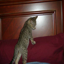

In [4]:
print(read_image(train_images[0], as_array=True).shape)
read_image(train_images[0])

In [5]:
train_images_resized = resize_images(train_images)
val_images_resized = resize_images(val_images)

Processed 250 of 2500
Processed 500 of 2500
Processed 750 of 2500
Processed 1000 of 2500
Processed 1250 of 2500
Processed 1500 of 2500
Processed 1750 of 2500
Processed 2000 of 2500
Processed 2250 of 2500
Processed 2500 of 2500
Processed 250 of 500
Processed 500 of 500


In [19]:
def generate_labels(images):
  labels = np.zeros((1, np.array(images).shape[0]), dtype=np.uint8)
  for i, img in enumerate(images):
    if re.findall('.+\/(\w+)\.\d+\.jpg', img)[0] == 'dog':
      labels[0][i] = 1
#     else:
#       labels[0][i] = 0
  return labels

In [20]:
y_train = generate_labels(train_images)
y_val = generate_labels(val_images)

In [22]:
def flatten_and_normalize_images(images):
  return images.reshape(images.shape[0], -1).T / 255

In [23]:
X_train = flatten_and_normalize_images(train_images_resized)
X_val = flatten_and_normalize_images(val_images_resized)

In [24]:
X_train.shape

(12288, 2500)

In [25]:
y_train.shape

(1, 2500)

## Building the Algorithm

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

In [26]:
def sigmoid(z):
  return 1 / (1 + np.exp(-1 * z))

In [27]:
def initialize_with_zeros(dim):
  w = np.zeros((dim, 1))
  b = 0
  return w, b

In [28]:
def negative_log_likelihood(A, y, m):
  return -1 * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A)) / m

In [29]:
def forward_propagate(w, b, X, y):
  m = X.shape[-1]
  A = sigmoid(np.dot(w.T, X) + b)
  cost = negative_log_likelihood(A, y, m)

  dw = np.dot(X, (A - y).T) / m
  db = np.sum(A - y) / m

  cost = np.squeeze(cost)
  grads = {"dw": dw, "db": db}

  return grads, cost


In [30]:
def optimize(w, b, X, y, num_iterations, learning_rate, verbose=False):
  costs = []
  
  for i in range(num_iterations):
    grads, cost = forward_propagate(w, b, X, y)
    dw = grads['dw']
    db = grads['db']
    
    w -= learning_rate * dw
    b -= learning_rate * db
    
    if i % 100 == 0:
      costs.append(cost)
      if verbose:
        print(f'cost after iteration {i}: {cost}')
  
  params = {'w': w, 'b': b}
  grads = {'dw': dw, 'db': db}
  
  return params, grads, costs

In [31]:
def predict(w, b, X):
  m = X.shape[-1]
  y_pred = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)
  
  A = sigmoid(np.dot(w.T, X) + b)
  
  for i in range(A.shape[1]):
    y_pred[0][i] = (A[0][i] > 0.5)
    
  return y_pred

In [36]:
def model(X_train, y_train, X_val, y_val, num_iterations=2000, learning_rate=0.5, verbose=False):
  w, b = initialize_with_zeros(X_train.shape[0])
  params, grads, costs = optimize(w, b, X_train, y_train, num_iterations, learning_rate, verbose)
  
  w = params['w']
  b = params['b']
  
  y_pred_train = predict(w, b, X_train)
  y_pred_val = predict(w, b, X_val)
  
  print(f'train accuracy: {(100 - np.mean(np.abs(y_pred_train - y_train)) * 100)}')
  print(f'test accuracy: {(100 - np.mean(np.abs(y_pred_val - y_val)) * 100)}')


  d = {"costs": costs,
       "y_prediction_test": y_pred_val, 
       "y_prediction_train" : y_pred_train, 
       "w" : w, 
       "b" : b,
       "learning_rate" : learning_rate,
       "num_iterations": num_iterations}
  
  return d

In [38]:
m = model(X_train, y_train, X_val, y_val, 2000, 0.5, True)

cost after iteration 0: 0.6931471805599454


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


cost after iteration 100: nan
cost after iteration 200: nan
cost after iteration 300: nan


KeyboardInterrupt: 